# 1. 必要なライブラリのインポート

In [7]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel

from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

# 2. 多次元のランダム関数を作成する仕組み

In [8]:
def build_random_function(dim, n_train=200, bounds=(-5.0, 5.0), seed=42):
    """
    dim 次元の領域 [bounds[0], bounds[1]]^dim で、
    ガウス過程を使った「ランダムな関数」を作る。
    
    具体的には:
      - 一様乱数で X_train を生成 (shape: (n_train, dim))
      - RBFカーネルをもつ GP を用意
      - X_train 上で GP からのサンプル y_train を取得
      - gpr.fit(X_train, y_train) で学習させる
      - 以後, objective_function(x) = gpr.predict(x) で関数値を返すようにする
    """
    rng = np.random.RandomState(seed)

    # X_train: [n_train, dim]
    X_train = rng.uniform(bounds[0], bounds[1], size=(n_train, dim))

    # GP (Scikit-Learn)
    kernel = RBF(length_scale=1.0)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, random_state=seed)

    # y_train: X_train 上でランダムな関数値をサンプリング
    # ここでは sample_y を使い、平均0のGPからランダムサンプルを得る
    y_train = gpr.sample_y(X_train, random_state=seed).ravel()

    # fit する (今の GPR は「平均0, 共分散=RBF」なGPからのサンプルを再度fitする形)
    gpr.fit(X_train, y_train)

    # 多次元最適解(だいたい)を探す => 大量サンプリングで最小値を探す
    # 注: 厳密には最適化してもいいが、単純ランダムでOK
    n_search = 500000
    X_search = rng.uniform(bounds[0], bounds[1], size=(n_search, dim))
    y_search = gpr.predict(X_search)
    global_opt_index = np.argmin(y_search)
    global_opt_val = y_search[global_opt_index]
    global_opt_point = X_search[global_opt_index]

    # まとめて返す
    return gpr, X_train, y_train, global_opt_point, global_opt_val

# 3. 多次元対応の objective_function を定義

In [9]:
class MultiDimObjective:
    """
    gpr.predict(x) を呼び出すだけの簡単なクラス。
    """
    def __init__(self, gpr, dim):
        self.gpr = gpr
        self.dim = dim

    def __call__(self, x):
        """
        x: torch.Tensor, shape = (..., dim)
           batched入力にも対応できるようにする
        戻り値: torch.Tensor, shape = (...,) または (..., 1)
        """
        # torch.Tensor => numpy
        if torch.is_tensor(x):
            x_np = x.detach().cpu().numpy()
        else:
            x_np = np.asarray(x, dtype=np.float32)

        # 2次元以上でもまとめて predict する
        # shape の最後が self.dim だと仮定
        x_2d = x_np.reshape(-1, self.dim)  # (batch, dim)
        y_pred = self.gpr.predict(x_2d)    # (batch, )

        # torch.Tensor に戻す
        y_tensor = torch.tensor(y_pred, dtype=torch.float32)

        # 入力の形状に合わせて reshape (ただし最後は1次元にしておく)
        return y_tensor

# 4. ECI_BO_Bandit クラス

In [10]:
class ECI_BO_Bandit:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, gamma=0.99):
        dtype = torch.float
        self.num_arms = 4

        self.A = torch.eye(dim, dtype=dtype)
        self.b = torch.zeros(dim, dtype=dtype)

        self.objective_function = objective_function
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.gamma = 1.0
        self.eval_history = [self.best_value] * n_initial
        self.arm_selection_history = []
        self.optimization_history = []
        self.saved_plot_files = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.best_value = self.Y.min().item()
        self.best_point = self.X[self.Y.argmin()]
        self.update_model()
        self.eval_history = [self.best_value] * self.n_initial

    def select_arm(self, total_iterations):
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        p_values = []
        alpha = 1.0

        for i in range(self.num_arms):
            x_arm = self.arms_features[i].view(-1, 1)
            mean = (theta.view(1, -1) @ x_arm).item()
            var = (x_arm.t() @ A_inv @ x_arm).item()
            ucb = mean + alpha * math.sqrt(var * math.log(total_iterations + 1))
            p_values.append(ucb)

        return int(np.argmax(p_values))

    def plot_gp_mean_variance(self, iteration, global_opt_point=None):
        if self.dim != 2:
            print(f"[plot_gp_mean_variance] dim={self.dim} のためスキップします。")
            return

        N = 100
        grid_vals = np.linspace(self.bounds[0,0].item(), self.bounds[1,0].item(), N)
        X_grid, Y_grid = np.meshgrid(grid_vals, grid_vals)
        XY = np.stack([X_grid.ravel(), Y_grid.ravel()], axis=-1)
        XY_torch = torch.tensor(XY, dtype=torch.float32)

        posterior = self.model.posterior(XY_torch)
        mean = posterior.mean.detach().numpy().reshape(N, N)
        var = posterior.variance.detach().numpy().reshape(N, N)

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        c1 = axes[0].contourf(X_grid, Y_grid, mean, levels=20, cmap='coolwarm')
        fig.colorbar(c1, ax=axes[0])
        axes[0].set_title(f"GP Mean (iter={iteration})")
        if global_opt_point is not None:
            axes[0].plot(global_opt_point[0], global_opt_point[1], 'g*', markersize=10, label='True Global Opt')
        axes[0].plot(self.best_point[0].item(), self.best_point[1].item(), 'r*', markersize=10, label='Current Best')
        axes[0].axis("equal")
        axes[0].legend()

        c2 = axes[1].contourf(X_grid, Y_grid, var, levels=20, cmap='coolwarm')
        fig.colorbar(c2, ax=axes[1])
        axes[1].set_title(f"GP Variance (iter={iteration})")
        if global_opt_point is not None:
            axes[1].plot(global_opt_point[0], global_opt_point[1], 'g*', markersize=10)
        axes[1].plot(self.best_point[0].item(), self.best_point[1].item(), 'r*', markersize=10)
        axes[1].axis("equal")

        plt.tight_layout()
        plot_dir = "plots"
        os.makedirs(plot_dir, exist_ok=True)
        filename = os.path.join(plot_dir, f"gp_posterior_{iteration}.png")
        plt.savefig(filename)
        plt.close(fig)

        self.saved_plot_files.append(filename)

    def optimize(self, global_opt_point=None):
        from tqdm.notebook import tqdm  # ← notebook上での進捗バー

        self.initialize()
        self.optimization_history = []
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float

        # --- tqdmの進捗バーで (n_max - n_initial) 回を可視化 ---
        with tqdm(total=self.n_max - self.n_initial, 
                  desc="Optimization (single run)", 
                  bar_format=TQDM_BAR_FORMAT) as pbar:

            while n < self.n_max:
                self.update_model()

                # 多次元対応: 正規乱数からランダム方向ベクトルを生成
                directions = torch.randn(self.num_arms, self.dim, dtype=dtype)
                norms = directions.norm(dim=1, keepdim=True)
                directions = directions / norms
                self.arms_features = directions

                selected_arm = self.select_arm(total_iterations)
                self.arm_selection_history.append(selected_arm)
                direction = self.arms_features[selected_arm]

                ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

                def eci_func(x):
                    x_scalar = x.squeeze(-1).squeeze(-1)
                    full_x = self.best_point.clone().unsqueeze(0)
                    full_x = full_x + x_scalar[:, None] * direction
                    full_x = full_x.unsqueeze(1)
                    return ei(full_x)

                one_d_bounds = torch.tensor([[self.bounds[0,0].item()], [self.bounds[1,0].item()]], dtype=dtype)

                candidate, acq_value = optimize_acqf(
                    eci_func,
                    one_d_bounds,
                    q=1,
                    num_restarts=10,
                    raw_samples=100,
                )

                new_x = self.best_point.clone() + candidate.squeeze() * direction
                new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)

                self.X = torch.cat([self.X, new_x.unsqueeze(0)])
                self.Y = torch.cat([self.Y, new_y])

                self.optimization_history.append(new_x.clone())

                improvement = max(0, self.best_value - new_y.item())
                if improvement > 0:
                    improvement = 1

                x_arm = direction.view(-1, 1)
                self.A = self.A + x_arm @ x_arm.t()
                self.b = self.b + improvement * direction

                if new_y.item() < self.best_value:
                    self.best_value = new_y.item()
                    self.best_point = new_x

                self.eval_history.append(self.best_value)

                # 50イテレーションごとにプロット
                if (n % 50) == 0:
                    self.plot_gp_mean_variance(n, global_opt_point=global_opt_point)

                n += 1
                total_iterations += 1

                # プログレスバーを1ステップ進める
                pbar.update(1)

        return self.best_point, self.best_value


# 5. メイン実行部

In [11]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

def main(dim=2, n_initial=10, n_iter=50, n_runs=3):
    bounds_np = np.array([[-5.0]*dim, [5.0]*dim])
    gpr, X_train, y_train, global_opt_point, global_opt_val = build_random_function(
        dim=dim, n_train=200, bounds=(-5, 5), seed=42
    )
    

# 実際に main() を呼び出してみる

Estimated global optimum value (approx): -1.866979256283615
Estimated global optimum point (approx): [ 0.08669585 -4.67014184 -1.29548857 -3.60036    -4.14490435]


All runs:   0%|          | 0/10 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Optimization (single run):   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[Run 1] best_f = -1.4418085813522339, best_x = tensor([3.0314, 1.2776, 0.3880, 3.9373, 2.9144])


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Optimization (single run):   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[Run 2] best_f = -1.5604667663574219, best_x = tensor([-0.4495,  1.2249, -2.2483, -3.0731, -0.3197])


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Optimization (single run):   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[Run 3] best_f = -1.7056366205215454, best_x = tensor([-3.8750,  3.2707, -3.7284, -1.0431,  3.0419])


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Optimization (single run):   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[Run 4] best_f = -1.6531263589859009, best_x = tensor([ 3.0792,  3.9574, -1.8137, -3.8947, -2.7114])


Optimization (single run):   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[Run 5] best_f = -1.7753032445907593, best_x = tensor([-3.2417, -1.9722,  0.2562, -0.5897, -2.0678])


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Optimization (single run):   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[Run 6] best_f = -1.9485430717468262, best_x = tensor([ 2.2603, -2.1722, -4.7353,  1.4845, -3.1560])


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Optimization (single run):   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[Run 7] best_f = -1.965588927268982, best_x = tensor([ 0.2855, -4.5196, -1.5099, -3.7303, -4.3140])


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Optimization (single run):   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[Run 8] best_f = -1.9048383235931396, best_x = tensor([-2.5982,  1.6896,  2.6175, -2.5861,  2.3153])


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

Optimization (single run):   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\optim\optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data i

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[Run 9] best_f = -1.2123724222183228, best_x = tensor([ 2.2552,  3.5556,  3.2513, -1.0499,  1.6008])


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Optimization (single run):   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[plot_gp_mean_variance] dim=5 のためスキップします。


C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\nomuyu\Documents\baysian_optimizatio

[Run 10] best_f = -1.4099212884902954, best_x = tensor([-0.8687, -4.1427,  4.9601,  0.0358,  0.9466])


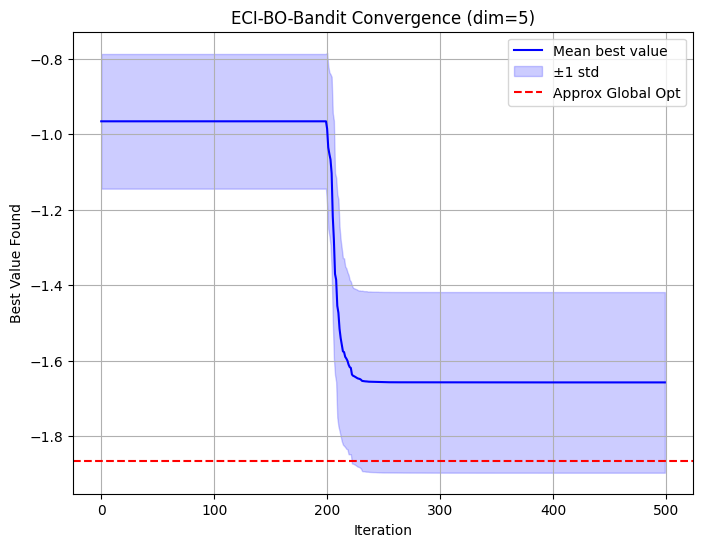

In [12]:
dim = 5
n_initial = 200
n_iter = 500
n_runs = 10
bounds_np = np.array([[-5.0]*dim, [5.0]*dim])
gpr, X_train, y_train, global_opt_point, global_opt_val = build_random_function(
    dim=dim, n_train=200, bounds=(-5, 5), seed=42
)


print(f"Estimated global optimum value (approx): {global_opt_val}")
print(f"Estimated global optimum point (approx): {global_opt_point}")

objective_func = MultiDimObjective(gpr, dim)

from tqdm.notebook import trange  # ← notebook用のループ進捗バー

all_eval_hist = []
all_arm_history = []

# --- 全体の試行(n_runs)をtrangeで可視化 ---
for run in trange(n_runs, desc="All runs", bar_format=TQDM_BAR_FORMAT):
    X_init = generate_initial_points(n_initial, dim, torch.tensor(bounds_np))
    eci_bo = ECI_BO_Bandit(X_init, objective_func, torch.tensor(bounds_np),
                               n_initial, n_iter, dim)
    best_x, best_f = eci_bo.optimize(global_opt_point=global_opt_point)
    print(f"[Run {run+1}] best_f = {best_f}, best_x = {best_x}")

    all_eval_hist.append(eci_bo.eval_history)
    all_arm_history.append(eci_bo.arm_selection_history)

# 収束プロット
all_eval_hist = np.array(all_eval_hist) 
mean_hist = np.mean(all_eval_hist, axis=0)
std_hist = np.std(all_eval_hist, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(mean_hist, label='Mean best value', color='blue')
plt.fill_between(range(len(mean_hist)),
                mean_hist - std_hist,
                mean_hist + std_hist,
                color='blue', alpha=0.2, label='±1 std')
plt.axhline(global_opt_val, color='red', linestyle='--', label='Approx Global Opt')
plt.xlabel("Iteration")
plt.ylabel("Best Value Found")
plt.legend()
plt.grid(True)
plt.title(f"ECI-BO-Bandit Convergence (dim={dim})")
plt.show()



In [13]:
# 2次元の場合のみ探索軌跡を可視化
if dim == 2:
    eci_bo_2d = eci_bo
    N_plot = 100
    x_vals = np.linspace(bounds_np[0,0], bounds_np[1,0], N_plot)
    y_vals = np.linspace(bounds_np[0,1], bounds_np[1,1], N_plot)
    X_grid, Y_grid = np.meshgrid(x_vals, y_vals)
    XY_plot = np.stack([X_grid.ravel(), Y_grid.ravel()], axis=-1)
    Z_plot = gpr.predict(XY_plot).reshape(N_plot, N_plot)

    plt.figure(figsize=(8,6))
    cp = plt.contourf(X_grid, Y_grid, Z_plot, levels=30, cmap='viridis')
    plt.colorbar(cp)
    plt.plot(global_opt_point[0], global_opt_point[1], 'r*', markersize=12, label='Approx Global Opt')
    traj = torch.stack(eci_bo_2d.optimization_history).detach().numpy()
    plt.plot(traj[:,0], traj[:,1], 'w.-', label='Search Trajectory')
    plt.title("Search Trajectory in 2D")
    plt.legend()
    plt.axis("equal")
    plt.show()